In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from molecule_info import MoleculeInfo
from subspace_expansion import SubspaceExpansion
import h4_experiment

def timestamp():
    return datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")


# Table 1, 3 and Fig. 2

Description of Parameters:
* n_trial [int]:  Number of trials to gather statistics for mean absolute error and standard deviation.
* n_lev["auto" or int]: Regularization parameter for the general eigenvalue problem. The maximum value is the dimension of the subspace. If "auto" is selected, n_lev is chosen to minimize the absolute error of estimation.
* subspace ["1n" or "2n1p"]: Choosing "1n" yields a subspace $S = Span\{a_i |\psi\rangle \}$, while "2n1p" yields a subspace $S = Span\{a_i a_j^\dagger a_k |\psi\rangle \}$.
* spin_supspace ["up", "down", or "all"]: Selecting "up(down)" yields a supspace $S = Span\{O_{i,\sigma=\uparrow(\downarrow) } |\psi\rangle \} $, while "all" yields a subspace $S = Span\{O_{i,\sigma\in\{\uparrow, \downarrow \}} |\psi\rangle \} $.
* cpu_assigned [int]: Number of CPUs assigned for the calculation.
* verbose [0, 1, 2]: Verbosity level for the calculation progress. To minimize output, set it to 0.
* load [bool]: If True, precomputed values are utilized for some calculations.
* write_result_matrix [bool]: If True, $\tilde{H}_{ij}$ and $\tilde{S}_{ij}$ are saved after the calculation."

In [17]:
params_fixed = {
    "n_trial": 10, 
    "n_lev": "auto", # parameter 
    "subspace": "1n",
    "spin_supspace": "up",
    "cpu_assigned": 10,
    "verbose": 1,
    "load": True,
    "write_result_matrix": True,
}
params_for_table = {}
results_for_table = {}
for method in ["CS", "qubit_wise_commuting","LBCS", "DCS", "OGM", "naive_LBCS", ]:
    for molecule_label, n_qubit in [("H2", 4), ("H2", 8), ("LiH", 10)]:
        for shots in [1000000, 100000, 10000, 1000]:
            if (molecule_label, n_qubit) == ("H2", 4) and shots > 1000:
                continue
            param_key = (molecule_label, n_qubit, shots, method)
            print("\n", param_key)
            params_for_table[param_key] = {
                "molecule": molecule_label,
                "n_qubits": n_qubit,
                "shots": shots,
                "method": method,
                "suffix": timestamp(),
                **params_fixed,
            }
            if method == "OGM":
                params_for_table[param_key]["OGM_param_T"] = 1000
                
            molecule = MoleculeInfo(params_for_table[param_key])
            subspace_expansion = SubspaceExpansion(params_for_table[param_key], molecule)
            err, std = subspace_expansion.execute_statistics(molecule)
            results_for_table[param_key] = {"err": err, "std": std}

In [89]:
results_for_table

{('H2', 4, 1000, 'CS'): {'err': 0.0425, 'std': 0.0516},
 ('H2', 8, 1000000, 'CS'): {'err': 0.01, 'std': 0.0113},
 ('H2', 8, 100000, 'CS'): {'err': 0.0228, 'std': 0.0208},
 ('H2', 8, 10000, 'CS'): {'err': 0.0417, 'std': 0.0455},
 ('H2', 8, 1000, 'CS'): {'err': 0.0872, 'std': 0.1138},
 ('LiH', 10, 1000000, 'CS'): {'err': 0.0282, 'std': 0.0201},
 ('LiH', 10, 100000, 'CS'): {'err': 0.0389, 'std': 0.0416},
 ('LiH', 10, 10000, 'CS'): {'err': 0.0501, 'std': 0.0918},
 ('LiH', 10, 1000, 'CS'): {'err': 0.2503, 'std': 0.4623},
 ('H2', 4, 1000, 'qubit_wise_commuting'): {'err': 0.0, 'std': 0.0},
 ('H2', 8, 1000000, 'qubit_wise_commuting'): {'err': 0.0377, 'std': 0.0025},
 ('H2', 8, 100000, 'qubit_wise_commuting'): {'err': 0.0427, 'std': 0.0069},
 ('H2', 8, 10000, 'qubit_wise_commuting'): {'err': 0.0352, 'std': 0.0322},
 ('H2', 8, 1000, 'qubit_wise_commuting'): {'err': 0.0726, 'std': 0.0844},
 ('LiH', 10, 1000000, 'qubit_wise_commuting'): {'err': 0.0187, 'std': 0.0079},
 ('LiH', 10, 100000, 'qubit_w

In [13]:
keys_mol = set([label[:3] for label in results_for_table.keys()])
df_dict = {}
df_dict["molecules"] = [f"{label[0]}_{label[1]}_qubit" for label in keys_mol]
df_dict["total_meas"] = [label[2] for label in keys_mol]
for method in ["naive_LBCS", "CS", "LBCS", "DCS", "qubit_wise_commuting", "OGM"]:
    df_dict[f"{method}_err"] = [
        results_for_table[key + (method,)]["err"] for key in keys_mol
    ]
    df_dict[f"{method}_std"] = [
        results_for_table[key + (method,)]["std"] for key in keys_mol
    ]
df_plot = pd.DataFrame(df_dict).rename(
    columns={
        col: col.replace("qubit_wise_commuting", "MCC")
        for col in df_dict
        if "qubit_wise_commuting" in col
    }
)
df_plot = df_plot.sort_values(["molecules", "total_meas"]).reset_index(drop=True)
df_plot

,molecules,total_meas,naive_LBCS_err,naive_LBCS_std,CS_err,CS_std,LBCS_err,LBCS_std,DCS_err,DCS_std,qwc_err,qwc_std,OGM_err,OGM_std
0,H2_4_qubit,1000,0.022554,0.024220,0.042479,0.051631,6.217249e-16,2.093457e-16,6.883383e-16,2.454795e-16,6.661338e-16,1.046728e-16,7.105427e-16,2.093457e-16
1,H2_8_qubit,1000,0.216718,0.228474,0.087239,0.113832,1.267059e-01,1.253869e-01,4.142098e-02,4.984047e-02,7.255506e-02,8.435854e-02,2.928537e-02,3.409652e-02
2,H2_8_qubit,10000,0.077704,0.103183,0.041735,0.045460,5.264951e-02,5.456479e-02,1.716332e-02,1.478045e-02,3.517690e-02,3.222745e-02,2.080176e-02,1.807792e-02
3,H2_8_qubit,100000,0.019669,0.022813,0.022759,0.020830,1.880336e-02,1.720618e-02,1.744002e-02,1.109171e-02,4.267442e-02,6.874072e-03,1.974252e-02,1.039778e-02
4,H2_8_qubit,1000000,0.008946,0.008468,0.010013,0.011300,1.642246e-02,1.111116e-02,2.228476e-02,1.283742e-03,3.773780e-02,2.549393e-03,2.136807e-02,2.793875e-03
5,LiH_10_qubit,1000,0.957140,0.997339,0.250269,0.462343,7.326362e-02,9.780863e-02,7.113009e-02,6.130311e-02,3.849539e-02,4.914450e-02,7.995991e-02,1.352775e-01
6,LiH_10_qubit,10000,0.114566,0.116610,0.050051,0.091793,4.167175e-02,3.408414e-02,2.130865e-02,2.586479e-02,2.616113e-02,1.377002e-02,3.416811e-02,2.365580e-02
7,LiH_10_qubit,100000,0.052460,0.044915,0.038937,0.041570,3.049068e-02,2.402008e-02,2.972684e-02,2.725193e-02,2.325806e-02,2.161001e-02,3.612016e-02,1.661403e-02
8,LiH_10_qubit,1000000,0.034573,0.037312,0.028199,0.020092,2.464823e-02,2.323795e-02,1.349503e-02,1.044423e-02,1.866009e-02,7.898823e-03,2.937985e-02,1.360788e-02


H2 8 qubit - Mean Absoute Error


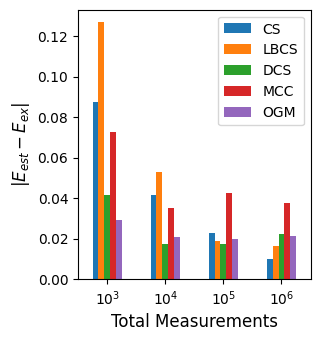

LiH 10 qubit - Mean Absoute Error


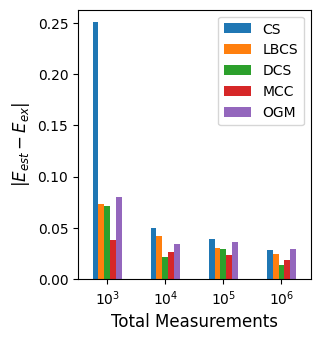

In [21]:
print("H2 8 qubit - Mean Absoute Error")
df_plot.query("molecules=='H2_8_qubit'").set_index("total_meas").drop(columns=["naive_LBCS_err"]).filter(like="err").plot.bar(rot=0,figsize=(3,3.5))
plt.legend(fontsize=10)
plt.ylabel("$|E_{est}-E_{ex}|$",fontsize=12)
plt.xlabel("Total Measurements",fontsize=12)
plt.xticks(plt.xticks()[0],[f"$10^{np.log10(int(tick.get_text())):.0f}$" for tick in  plt.xticks()[1]])
plt.legend([col.split("_")[0].replace("qwc","MCC") for col in df_plot.filter(like="err").columns if "naive_LBCS_err" not in col])
plt.savefig("../qse_err_h2_8.pdf",bbox_inches='tight')
plt.show()

print("LiH 10 qubit - Mean Absoute Error")
df_plot.query("molecules=='LiH_10_qubit'").set_index("total_meas").drop(columns=["naive_LBCS_err"]).filter(like="err").plot.bar(rot=0,figsize=(3,3.5))
plt.legend(fontsize=10)
plt.ylabel("$|E_{est}-E_{ex}|$",fontsize=12)
plt.xlabel("Total Measurements",fontsize=12)
plt.xticks(plt.xticks()[0],[f"$10^{np.log10(int(tick.get_text())):.0f}$" for tick in  plt.xticks()[1]])
plt.legend([col.split("_")[0].replace("qwc","MCC") for col in df_plot.filter(like="err").columns if "naive_LBCS_err" not in col])
plt.savefig("../qse_err_lih_10.pdf",bbox_inches='tight')
plt.show()

H2 8 qubit - Standard Deviation


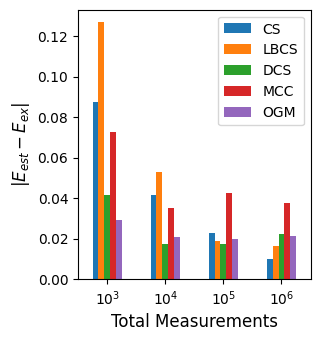

LiH 10 qubit - Standard Deviation


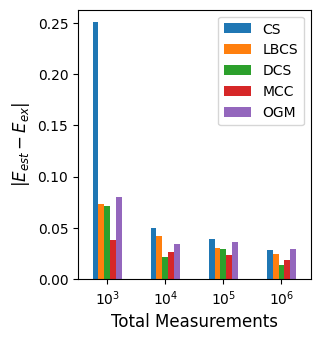

In [20]:
print("H2 8 qubit - Standard Deviation")
df_plot.query("molecules=='H2_8_qubit'").set_index("total_meas").drop(columns=["naive_LBCS_err"]).filter(like="err").plot.bar(rot=0,figsize=(3,3.5))
plt.legend(fontsize=10)
plt.ylabel("$|E_{est}-E_{ex}|$",fontsize=12)
plt.xlabel("Total Measurements",fontsize=12)
plt.xticks(plt.xticks()[0],[f"$10^{np.log10(int(tick.get_text())):.0f}$" for tick in  plt.xticks()[1]])
plt.legend([col.split("_")[0].replace("qwc","MCC") for col in df_plot.filter(like="err").columns if "naive_LBCS_err" not in col])
plt.savefig("../qse_err_h2_8.pdf",bbox_inches='tight')
plt.show()

print("LiH 10 qubit - Standard Deviation")
df_plot.query("molecules=='LiH_10_qubit'").set_index("total_meas").drop(columns=["naive_LBCS_err"]).filter(like="err").plot.bar(rot=0,figsize=(3,3.5))
plt.legend(fontsize=10)
plt.ylabel("$|E_{est}-E_{ex}|$",fontsize=12)
plt.xlabel("Total Measurements",fontsize=12)
plt.xticks(plt.xticks()[0],[f"$10^{np.log10(int(tick.get_text())):.0f}$" for tick in  plt.xticks()[1]])
plt.legend([col.split("_")[0].replace("qwc","MCC") for col in df_plot.filter(like="err").columns if "naive_LBCS_err" not in col])
plt.savefig("../qse_err_lih_10.pdf",bbox_inches='tight')
plt.show()

# Fig. 3 (Left)

In [27]:
energies_rigorous, energies_2n1p_gs, energies_2n1p_cisd = h4_experiment.simulate_energy_vs_interatomic_distance()

100%|██████████| 40/40 [01:17<00:00,  1.93s/it]


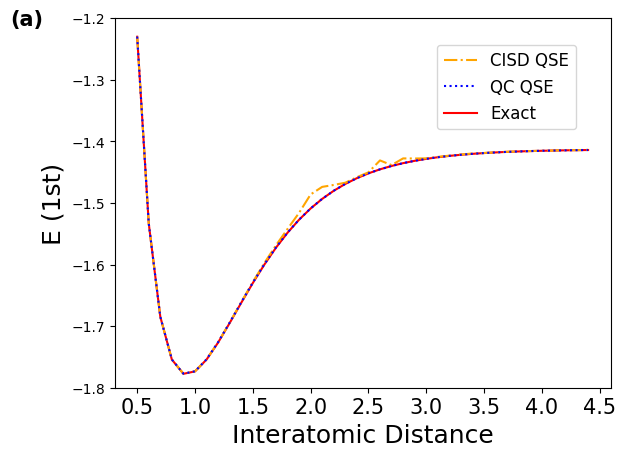

In [30]:
plt.plot(np.arange(0.5, 4.5, 0.1),energies_2n1p_cisd, label="CISD QSE", color = "Orange", linestyle="-.", zorder=0)
plt.plot(np.arange(0.5, 4.5, 0.1),energies_2n1p_gs, label="QC QSE", color = "Blue", linestyle=":", zorder=1)
plt.plot(np.arange(0.5, 4.5, 0.1),energies_rigorous, label="Exact", color="red", zorder=-1)
plt.ylabel("E (1st)",fontsize=18)
plt.xlabel("Interatomic Distance",fontsize=18)
plt.ylim(-1.8, -1.2)
plt.legend(loc=(0.65, 0.7),fontsize=12)
plt.minorticks_off()
plt.xticks(fontsize=15)
plt.text(-0.6, -1.2116, '(a)', fontsize=15, weight='bold')
# plt.savefig("E_vs_distance.pdf",bbox_inches='tight')
plt.show()


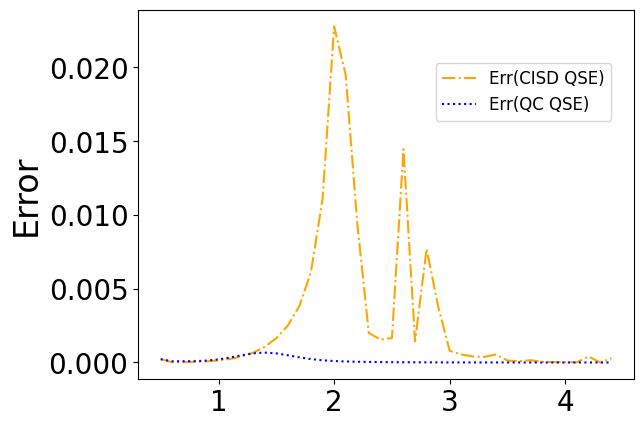

In [62]:
plt.plot(np.arange(0.5, 4.5, 0.1),abs(np.array(energies_rigorous)-np.array(energies_2n1p_cisd)),
         label="Err(CISD QSE)", color = "Orange", linestyle="-.", zorder=0)
plt.plot(np.arange(0.5, 4.5, 0.1),abs(np.array(energies_rigorous)-np.array(energies_2n1p_gs)),
        label="Err(QC QSE)", color = "Blue", linestyle=":", zorder=1)
plt.ylabel("Error",fontsize=24)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(loc=(0.6, 0.7),fontsize=12)
plt.minorticks_off()

plt.show()

# Fig. 3 (Right)

In [56]:
energy_excited_exact, energy_excited_cisd, energies_excited = h4_experiment.simulate_qse_convergence()

RUN[0-0] E excited (QSE)  -1.5081996714859993
RUN[1-0] E excited (QSE)  -1.5094368403409826
RUN[2-0] E excited (QSE)  -1.5081277740392165
RUN[3-0] E excited (QSE)  -1.509232318943996
RUN[4-0] E excited (QSE)  -1.5088639565737447
RUN[5-0] E excited (QSE)  -1.5087433741936218
RUN[6-0] E excited (QSE)  -1.5096076685939042
RUN[0-1] E excited (QSE)  -1.5102217623927685
RUN[7-0] E excited (QSE)  -1.5081361308098773
RUN[1-1] E excited (QSE)  -1.50909465938554
RUN[8-0] E excited (QSE)  -1.5090319962443297
RUN[2-1] E excited (QSE)  -1.5087868536345383
RUN[9-0] E excited (QSE)  -1.507620164942107
RUN[3-1] E excited (QSE)  -1.5085673697608735
RUN[4-1] E excited (QSE)  -1.5083499008940733
RUN[5-1] E excited (QSE)  -1.50806876411602
RUN[0-2] E excited (QSE)  -1.5094409283146693
RUN[6-1] E excited (QSE)  -1.5081696711849977
RUN[7-1] E excited (QSE)  -1.509049274459982
RUN[1-2] E excited (QSE)  -1.5090712322721245
RUN[8-1] E excited (QSE)  -1.5086461754482594
RUN[2-2] E excited (QSE)  -1.509180442035

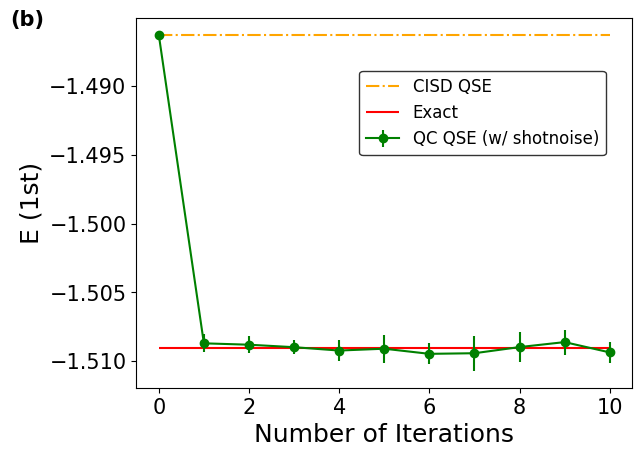

In [57]:
n_iter=10

plt.rcParams["font.size"] = 15 
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams["xtick.top"] = False
plt.rcParams["ytick.right"] = False

plt.errorbar(range(0,n_iter+1), 
             np.hstack([[energy_excited_cisd], np.mean(energies_excited,axis=0)]),
             yerr=np.hstack([[0], np.std(energies_excited,ddof=1,axis=0)]), 
             fmt='-o', color="green", label="QC QSE (w/ shotnoise)")
plt.hlines(y = energy_excited_cisd, xmin = 0, xmax = 10, color = "Orange", label = "CISD QSE",linestyles="-.")
plt.hlines(y = energy_excited_exact, xmin = 0, xmax = 10, color = "red", label = "Exact",zorder=0)
plt.legend( loc=(0.45, 0.63),fontsize=12, edgecolor='black')
plt.ylabel("E (1st)",fontsize=18)
plt.xlabel("Number of Iterations",fontsize=18)
plt.minorticks_off()
plt.text(-3.3, -1.4856, '(b)', fontsize=15, weight='bold')
# plt.savefig("E_vs_iter_2p1n_shot_1e8_without_dense.pdf",bbox_inches='tight')
plt.show()